#### https://ekdud7667.tistory.com/entry/KNN-CFCollaborative-Filtering-%EA%B5%AC%ED%98%84

# 1. Data

In [5]:
import pandas as pd
import numpy as np

dir_path = "datas/movielens_small/{}"
rating_data = pd.read_csv(dir_path.format("ratings.csv"))
movie_data = pd.read_csv(dir_path.format("movies.csv"))

In [6]:
crow, ccol = rating_data.shape
print("Rating Data")
print("[count] row : {}, column : {}".format(crow, ccol))
rating_data.head()

Rating Data
[count] row : 100004, column : 4


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
crow, ccol = movie_data.shape
print("Movie Data")
print("[count] row : {}, column : {}".format(crow, ccol))
movie_data.head()

Movie Data
[count] row : 9125, column : 3


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# merge data
merge_data = pd.merge(
                rating_data.drop("timestamp", axis=1), movie_data.drop('genres', axis=1), 
                how='outer', on='movieId')[['userId', 'movieId', 'rating']]
crow, ccol = merge_data.shape
print("Merge Data : Left Outer Join, User - Movie")
print("[count] row : {}, column : {}".format(crow, ccol))
merge_data.head()

Merge Data : Left Outer Join, User - Movie
[count] row : 100063, column : 3


,userId,movieId,rating
0,1.0,31,2.5
1,7.0,31,3.0
2,31.0,31,4.0
3,32.0,31,4.0
4,36.0,31,3.0


Explicit Feedback으로 분류되는 평점 데이터는 대부분 인기가 많은 영화들이다.


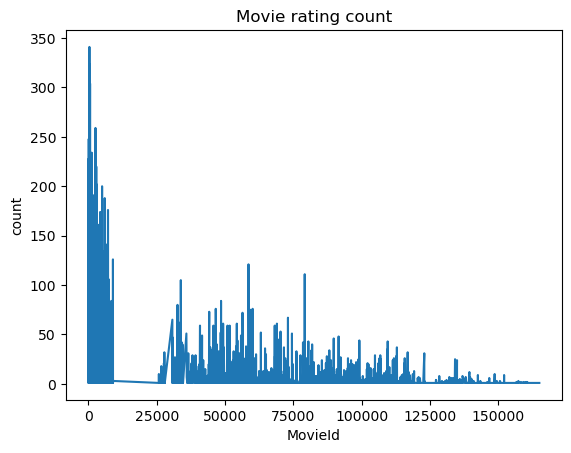

,userId,movieId,rating
0,1.0,31,2.5
1,7.0,31,3.0
2,31.0,31,4.0
3,32.0,31,4.0
4,36.0,31,3.0


In [20]:
# Analsys : Distribute Check
import matplotlib.pyplot as plt

movie_ids = merge_data['movieId']
count_group = merge_data['movieId'].groupby(movie_ids).count()
movie_id, count = count_group.index, count_group.values

print("Explicit Feedback으로 분류되는 평점 데이터는 대부분 인기가 많은 영화들이다.")

plt.plot(movie_id, count)
plt.title("Movie rating count")
plt.xlabel("MovieId")
plt.ylabel("count")
plt.show()

merge_data.head()

# 2. Data Preprocessing

In [148]:
# Pivotting
usr_movie_features = rating_data.pivot(index="userId", columns="movieId", values="rating").fillna(0)

usr_movie_features.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
# cold start problem
zero_datas = np.zeros(usr_movie_features.columns.size).astype(float)
usr_movie_features.loc[usr_movie_features.index.size + 1] = zero_datas

usr_movie_features.tail(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
663,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# convert matrix
mat = usr_movie_features.to_numpy()

print("matrix size : {}".format(mat.shape))

matrix size : (672, 9066)


In [151]:
zero_datas

array([0., 0., 0., ..., 0., 0., 0.])

# 3. Model Setting

In [152]:
from sklearn.neighbors import NearestNeighbors

metric = "cosine"
algorithm = "auto"
n_negihbors = 10

knn = NearestNeighbors(
            metric=metric, 
            algorithm=algorithm, 
            n_neighbors=n_negihbors, 
            n_jobs=n_jobs)
knn.fit(mat)

# row - user idx, col - 유사도 결과값, 이웃들의 index
similarity_values, usr_neighbors = knn.kneighbors()

# 4. Analysis

In [153]:
# 나의 이웃들은 어떤 영화를 시청하고 있을까?
target_user_id = 672
# knn이 반환하는 similarity_values, usr_neighbors는 zero-index
target_user_idx = target_user_id - 1

target_user_ratings = usr_movie_features.loc[target_user_id].values
target_user_neighbors = usr_neighbors[target_user_idx]

print("user neighbors : {}".format(",".join(target_user_neighbors.astype(str).tolist())))

user neighbors : 453,444,445,446,447,448,449,450,442,452


## Best-Case 

In [157]:
# 가장 유사했던 이웃 (가장 클수록 유사함)
neighbor_idx = target_user_neighbors[n_negihbors - 1]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가장 가까운 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가장 가까운 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가장 가까운 이웃과 나는 ----
-- 0개의 영화를 똑같이 시청하셨어요!


나와 가장 가까운 이웃은 ----
0개의 영화도 추가로 시청하셨습니다!





In [158]:
# 가장 유사도가 떨어지는 이웃
neighbor_idx = target_user_neighbors[0]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가까운 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가까운 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가까운 이웃과 나는 ----
-- 0개의 영화를 똑같이 시청하셨어요!


나와 가까운 이웃은 ----
0개의 영화도 추가로 시청하셨습니다!





## Worst-Case

In [159]:
# KNN은 아래와 같이 코사인 유사도 방식으로 동작한다.
from sklearn.metrics.pairwise import cosine_similarity as cos

target_ratings = usr_movie_features.loc[target_user_id].values
target_ratings = np.expand_dims(target_ratings, axis=0)

all_ratings = usr_movie_features.to_numpy()
similarity_values = cos(target_ratings, all_ratings)[0]

sort_index = similarity_values.argsort()

neighbor_idx = sort_index[0]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가장 가까웃 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가장 가까웃 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가장 가까웃 이웃과 나는 ----
-- 0개의 영화를 똑같이 시청하셨어요!


나와 가장 가까웃 이웃은 ----
0개의 영화도 추가로 시청하셨습니다!



